# Pilot - Bi-LSTM with Attention for Sentiment Analysis on Amazon Fine Food Reviews

This notebook implements a pilot Bi-LSTM model with attention for binary sentiment analysis on the Amazon Fine Food Reviews dataset. The model classifies reviews as positive (score > 3) or negative (score < 3), excluding neutral reviews (score = 3).

## Objectives
- Develop a contextual model using GloVe embeddings and Bi-LSTM with attention as a pilot for comparison with TF-IDF and BERT.
- Achieve macro-F1 ≥0.95 to validate the approach.
- Provide interpretable predictions using attention weight visualization.
- Ensure reproducibility with fixed seeds and pinned dependencies.
- Analyze errors to identify limitations and align with BERT/TF-IDF analyses.
- Display plots inline for presentation and save to `figures/bilstm`.

## Structure
1. Environment setup and data loading from Google Drive.
2. Preprocessing with whitespace tokenization, GloVe embeddings, and 80/20 train-test split.
3. Bi-LSTM model with attention, trained with class-weighted loss.
4. Evaluation with accuracy, macro-F1, and confusion matrix.
5. Interpretability via attention weight visualization for 3 test samples.
6. Error analysis for misclassified samples.
7. Visualization of loss curves and performance metrics.

Run cells sequentially after mounting Google Drive.

In [ ]:
# Environment & repo
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/fyp-code/amazon-sentiment-fyp

# Install dependencies
!pip install -q torch==2.2.1 torchtext==0.17.1 torchmetrics scikit-learn pandas matplotlib numpy tqdm

# Suppress NumPy 2.0 warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*NumPy 2.*")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/fyp-code/amazon-sentiment-fyp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 57.6 MB/s eta 0:00:00
ERROR: pip's depende

In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe, build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pathlib
import json
import math
import seaborn as sns


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data loading
ds_path = pathlib.Path("data/raw/Reviews.csv")
assert ds_path.exists(), "Expected Reviews.csv in data/raw/"

In [ ]:
# Load and preprocess data
"""
Data Preprocessing:
- Load Reviews.csv, selecting 'Text' and 'Score' columns.
- Remove neutral reviews (Score=3).
- Label as positive (Score>3) = 1, negative (Score<3) = 0.
- Split 80% train, 20% test with stratification to maintain class balance.
"""
RAW_COLS = ["Text", "Score"]
df = pd.read_csv(ds_path, usecols=RAW_COLS)
df = df[df.Score != 3]
df["label"] = (df.Score > 3).astype(int)
df = df.rename(columns={"Text": "text"})

# Splits
train_df, test_df = train_test_split(
    df[["text", "label"]], test_size=0.20, stratify=df.label, random_state=SEED)
print("Train size:", len(train_df), " | Test size:", len(test_df))

Train size: 420651  | Test size: 105163


In [ ]:
# Vocabulary and embeddings
"""
Tokenization and Embeddings:
- Uses whitespace tokenization for simplicity.
- Builds vocabulary with min_freq=2, adding <pad> and <unk> tokens.
- Loads GloVe 300D embeddings, mapping tokens to vectors.
- Sets <pad> token embedding to zeros.
"""
TOKENIZER = str.split
specials = ["<pad>", "<unk>"]

def yield_tokens(data_iter):
    for text in data_iter:
        yield TOKENIZER(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_df.text), min_freq=2, specials=specials)
vocab.set_default_index(vocab["<unk>"])
print("Vocab size:", len(vocab))

# Load GloVe 300D
vectors = GloVe(name="6B", dim=300)
embed_dim = 300
embedding_matrix = torch.randn(len(vocab), embed_dim)
for idx, token in enumerate(vocab.get_itos()):
    if token in vectors.stoi:
        embedding_matrix[idx] = vectors[token]
embedding_matrix[vocab["<pad>"]] = torch.zeros(embed_dim)

Vocab size: 225279


In [ ]:
# Dataset and DataLoader
"""
Dataset:
- Truncates reviews to MAX_LEN=100 tokens to balance memory and information.
- Pads sequences with <pad> token.
- Returns token IDs, labels, and sequence lengths.
"""
MAX_LEN = 100
PAD_IDX = vocab["<pad>"]

class ReviewDataset(Dataset):
    def __init__(self, frame):
        self.texts = frame.text.tolist()
        self.labels = frame.label.tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        tokens = TOKENIZER(self.texts[idx])[:MAX_LEN]
        ids = [vocab[t] for t in tokens]
        seq_len = len(ids)
        if seq_len < MAX_LEN:
            ids += [PAD_IDX] * (MAX_LEN - seq_len)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long), seq_len

def collate(batch):
    ids, labels, seq_lens = zip(*batch)
    return torch.stack(ids), torch.stack(labels), torch.tensor(seq_lens)

train_ds = ReviewDataset(train_df)
test_ds = ReviewDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_ds, batch_size=128, collate_fn=collate)

In [ ]:
# Model definition
"""
Model: Bi-LSTM with Attention
- Embedding: GloVe 300D, trainable.
- LSTM: 2 layers, 256 hidden units, bidirectional, 30% dropout.
- Attention: Scaled dot-product to focus on relevant tokens.
- Output: Linear layer to 2 classes (Neg, Pos).
"""
class BiLSTMAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim=256, num_layers=2, n_classes=2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True,
            batch_first=True, dropout=0.3)
        self.scale = 1.0 / math.sqrt(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)
    def forward(self, x, seq_lens, return_attn=False):
        embed = self.embedding(x)
        lstm_out, _ = self.lstm(embed)
        mask = (x != PAD_IDX)
        attn_scores = torch.bmm(lstm_out, lstm_out.transpose(1, 2)) * self.scale
        attn_scores = attn_scores.masked_fill(~mask.unsqueeze(1), -1e9)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.bmm(attn_weights, lstm_out)
        pooled = context.mean(dim=1)
        out = self.dropout(pooled)
        logits = self.fc(out)
        if return_attn:
            return logits, attn_weights
        return logits

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttn(len(vocab), embed_dim).to(device)

class_weights = torch.tensor([5.0, 1.0], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
# Training loop with loss tracking
"""
Training:
- Tracks loss per epoch for visualization.
- Uses class-weighted loss to handle 84:16 imbalance.
- Trains for 5 epochs, batch size 128, on GPU.
"""
EPOCHS = 5
train_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss, n = 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for ids, labels, seq_lens in pbar:
        ids, labels = ids.to(device), labels.to(device)
        logits = model(ids, seq_lens)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * ids.size(0)
        n += ids.size(0)
        pbar.set_postfix({"loss": f"{total_loss/n:.4f}"})
    train_losses.append(total_loss / n)

Epoch 1/5:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/3287 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/3287 [00:00<?, ?it/s]

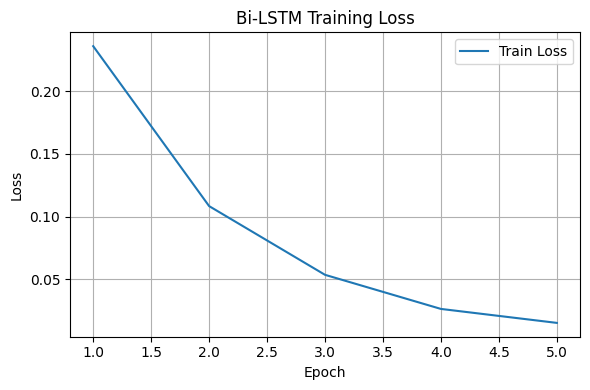

In [ ]:
# Plot loss curves
"""
Loss Curves:
- Visualizes training loss to assess convergence.
- Displays inline and saves to figures/bilstm/loss_curves.png.
"""
RES_DIR = pathlib.Path("results/bilstm")
FIG_DIR = pathlib.Path("figures/bilstm")
RES_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Bi-LSTM Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_DIR / "loss_curves.png", dpi=150)
plt.show()
plt.close()

Test:   0%|          | 0/822 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

         Neg     0.8621    0.8666    0.8644     16407
         Pos     0.9753    0.9744    0.9748     88756

    accuracy                         0.9576    105163
   macro avg     0.9187    0.9205    0.9196    105163
weighted avg     0.9577    0.9576    0.9576    105163



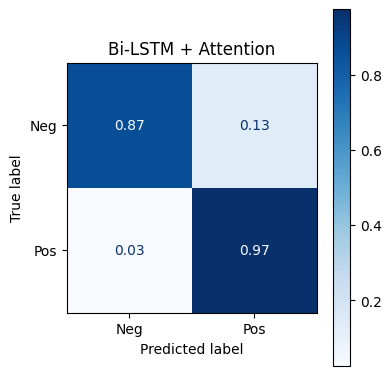

In [ ]:
# Evaluation
"""
Evaluation:
- Reports precision, recall, F1, accuracy, and macro-F1.
- Displays confusion matrix inline and saves to figures/bilstm/bilstm_cm.png.
- Saves metrics to results/bilstm/bilstm_metrics.json.
"""
model.eval()
preds, gold = [], []
with torch.no_grad():
    for ids, labels, seq_lens in tqdm(test_loader, desc="Test"):
        logits = model(ids.to(device), seq_lens)
        preds.extend(logits.argmax(1).cpu().tolist())
        gold.extend(labels.tolist())

rpt = classification_report(gold, preds, digits=4, target_names=["Neg", "Pos"])
print("\nClassification Report:\n", rpt)
json.dump(classification_report(gold, preds, output_dict=True),
          open(RES_DIR / "bilstm_metrics.json", "w"), indent=2)

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(gold, preds, normalize="true")
ConfusionMatrixDisplay(cm, display_labels=["Neg", "Pos"]).plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Bi-LSTM + Attention")
plt.tight_layout()
plt.savefig(FIG_DIR / "bilstm_cm.png", dpi=150)
plt.show()
plt.close()

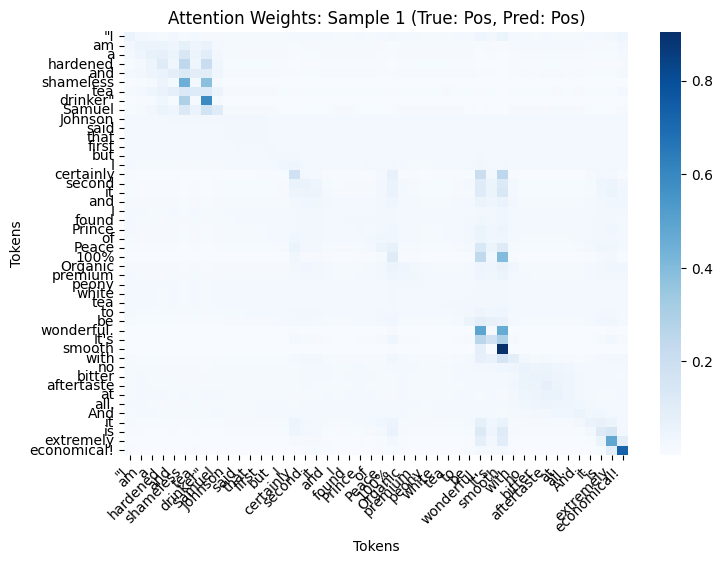


Sample 1: "I am a hardened and shameless tea drinker" Samuel Johnson said that first but I certainly second it...
True Label: Pos
Predicted: Pos


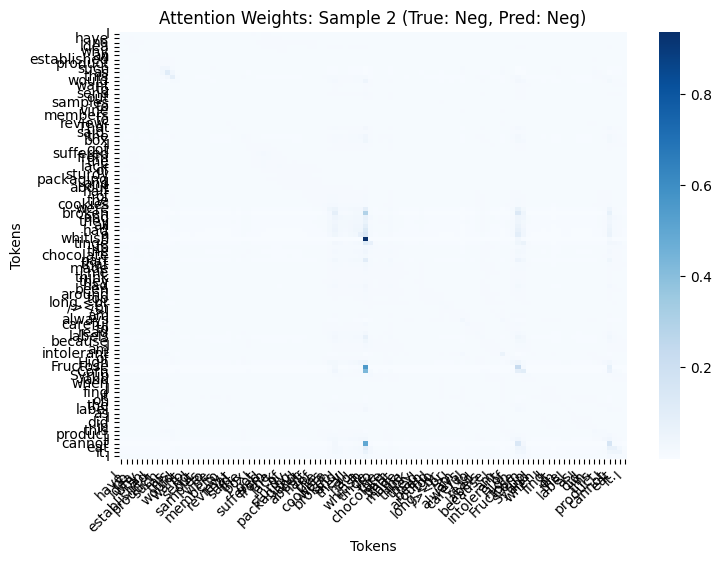


Sample 2: I have no idea why an established product such as this would want to send out samples to vine member...
True Label: Neg
Predicted: Neg


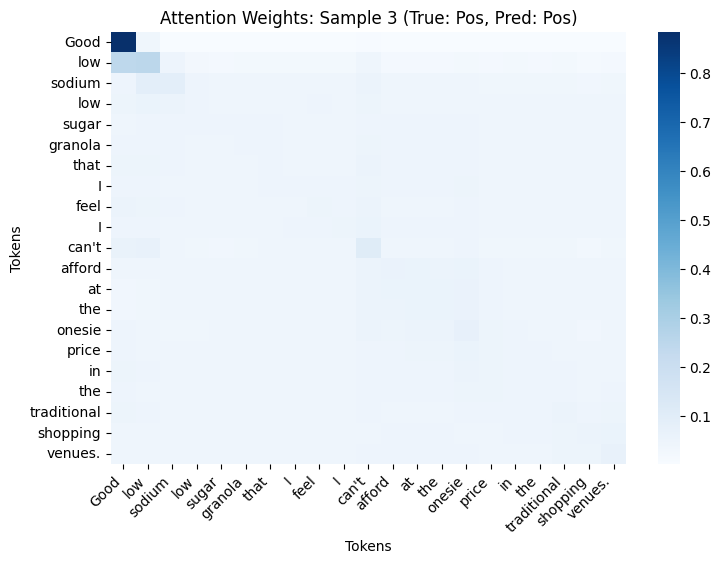


Sample 3: Good low sodium low sugar granola that I feel I can't afford at the onesie price in the traditional ...
True Label: Pos
Predicted: Pos


In [ ]:
# Assign predictions to test_df (needed for interpretability and error analysis)
test_df["pred"] = preds

# Interpretability with attention weights
"""
Interpretability:
- Visualizes attention weights for 3 test samples to show token importance.
- Displays heatmaps inline and saves to figures/bilstm/attn_*.png.
"""
model.eval()
sample_texts = test_df["text"].sample(3, random_state=SEED).tolist()
sample_indices = test_df["text"].sample(3, random_state=SEED).index
sample_labels = test_df.loc[sample_indices, "label"].tolist()
sample_preds = test_df.loc[sample_indices, "pred"].tolist()

for i, (text, true_label, pred) in enumerate(zip(sample_texts, sample_labels, sample_preds)):
    tokens = TOKENIZER(text)[:MAX_LEN]
    ids = [vocab[t] for t in tokens]
    seq_len = len(ids)
    if seq_len < MAX_LEN:
        ids += [PAD_IDX] * (MAX_LEN - seq_len)
    ids_tensor = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        _, attn_weights = model(ids_tensor, torch.tensor([seq_len]), return_attn=True)
    attn = attn_weights[0, :seq_len, :seq_len].cpu().tolist()  # Convert to list instead of numpy

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="Blues")
    plt.title(f"Attention Weights: Sample {i+1} (True: {'Pos' if true_label == 1 else 'Neg'}, Pred: {'Pos' if pred == 1 else 'Neg'})")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout(pad=2.0)
    plt.savefig(FIG_DIR / f"attn_{i}.png", dpi=150)
    plt.show()
    plt.close()
    print(f"\nSample {i+1}: {text[:100]}...")
    print(f"True Label: {'Pos' if true_label == 1 else 'Neg'}")
    print(f"Predicted: {'Pos' if pred == 1 else 'Neg'}")

In [ ]:
# Error analysis
"""
Error Analysis:
- Identifies misclassified test samples.
- Prints 3 examples with true/predicted labels.
"""
errors = test_df[test_df["label"] != test_df["pred"]]
print("\nError Analysis: Sample Misclassifications")
for i, row in errors.sample(3, random_state=SEED).iterrows():
    print(f"\nReview: {row['text'][:200]}...")
    print(f"True Label: {'Pos' if row['label'] == 1 else 'Neg'}")
    print(f"Predicted: {'Pos' if row['pred'] == 1 else 'Neg'}")


Error Analysis: Sample Misclassifications

Review: The best there is of the bunch, but why isn't Amazon carrying their most wanted product?<br /><br />Those sellers that do have it are charging 3-4 times the market value for it.<br /><br />What's goin...
True Label: Pos
Predicted: Neg

Review: I ordered this product without reading reviews because I saw it on Dr. Oz. Well I have had it for a few weeks and so far I don't see any difference. I know these things take time, however, frankly I h...
True Label: Neg
Predicted: Pos

Review: I had seen the commercials for the Healthy Choice Fresh Mixers and I felt like that was a really clever idea and an easy meal for lunch. The process to make the meal is pretty easy-take the sauce port...
True Label: Neg
Predicted: Pos
